# Installing LIME

In [ ]:
!pip install lime
import lime
import lime.lime_tabular

# Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
import tensorflow 
import tensorflow.keras 

# Load CIFAR10

In [ ]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()

class_mapping = {0:'airplane',
                 1:'automobile',
                 2:'bird',
                 3:'cat',
                 4:'deer',
                 5:'dog',
                 6:'frog',
                 7:'horse',
                 8:'ship',
                 9:'truck'}

# Display the image

Text(0.5, 1.0, 'Class: frog [6]')

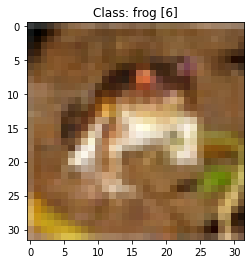

In [ ]:
index = 0 
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_train[0], interpolation = 'none')
ax1.set_title('Class: {} {}'.format(class_mapping.get(int(y_train[0])), y_train[0]))

# Explaining Images

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys

from lime import lime_image

index = np.random.randint(100)
test_image = x_test[index]

print(test_image.shape)

(32, 32, 3)


# Load model

In [ ]:
saved_weights = '/content/drive/MyDrive/MasterThesis/saved_models/cifar10_resnet_model.0.h5'
model = tensorflow.keras.models.load_model(saved_weights)

print(model.summary())

# Create the explanation object

In [ ]:
explainer = lime_image.LimeImageExplainer()

# Explain the input

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_image.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 668 ms, total: 13.9 s
Wall time: 11.9 s


# Top-5 predictions for a given input

(32, 32, 3)
1


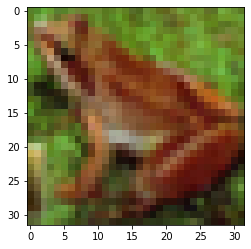

In [ ]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
print(test_image.shape)
plt.imshow(test_image)
preds = model.predict(np.expand_dims(test_image, axis=0))
print(np.argmax(preds))

In [ ]:
from skimage.segmentation import mark_boundaries

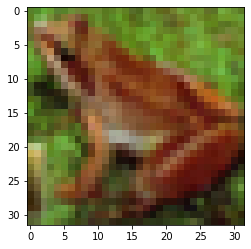

Text(0.5, 1.0, 'thresholded color coding')

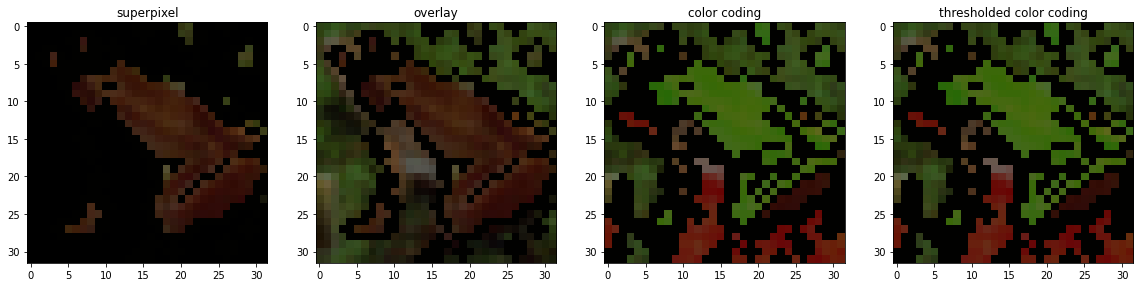

In [ ]:
def plot():
    plt.imshow(test_image)
    plt.show()

    plt.figure(figsize=(25, 8))

    plt.subplot(1, 5, 1)
    temp_sup, mask_sup = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp_sup / 2 + 0.5, mask_sup).astype(np.uint8))
    plt.title('superpixel')

    plt.subplot(1, 5, 2)
    temp_over, mask_over = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp_over / 2 + 0.5, mask_over).astype(np.uint8))
    plt.title('overlay')

    plt.subplot(1, 5, 3)
    temp_color, mask_color = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp_color / 2 + 0.5, mask_color).astype(np.uint8))
    plt.title('color coding')

    plt.subplot(1, 5, 4)
    temp_color_thresh, mask_color_thresh = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.05)
    plt.imshow(mark_boundaries(temp_color_thresh / 2 + 0.5, mask_color_thresh).astype(np.uint8))
    plt.title('thresholded color coding')

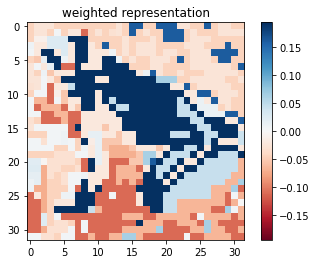

In [ ]:
def plot_weighted():
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap_weight = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap_weight, cmap = 'RdBu', vmin  = -heatmap_weight.max(), vmax = heatmap_weight.max())
    plt.title('weighted representation')
    plt.colorbar()

In [ ]:
# Reference 
# https://github.com/marcotcr/lime/blob/fd7eb2e6f760619c29fca0187c07b82157601b32/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb